<a href="https://colab.research.google.com/github/SaptarshiSen-1/Recognize-a-digit-using-pytorch/blob/main/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch 1 Test Acc: 97.62%
Epoch 2 Test Acc: 98.19%
Epoch 3 Test Acc: 98.41%
Epoch 4 Test Acc: 98.72%
Epoch 5 Test Acc: 98.56%
Epoch 6 Test Acc: 98.84%
Epoch 7 Test Acc: 98.51%
Epoch 8 Test Acc: 98.71%


Saving Screenshot 2025-08-08 230156.png to Screenshot 2025-08-08 230156 (5).png


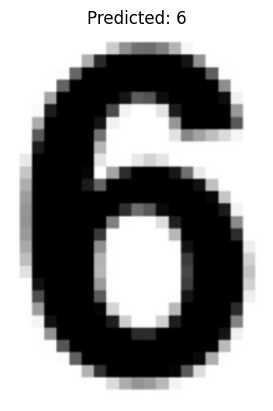

In [10]:
#Imports:core libraries used in this script
import torch, torchvision                               # PyTorch core and torchvision utilities
import torch.nn as nn                                   # neural network layers and modules
import torch.optim as optim                             # optimization algorithms
from torchvision import transforms, datasets            # common transforms and datasets (MNIST)
from torch.utils.data import DataLoader                 # creates iterable over dataset in batches
import matplotlib.pyplot as plt                         # plotting images / results
from PIL import Image, ImageOps                         # Pillow: image loading and simple ops (invert, resize)
import numpy as np, io                                  # numpy for numeric ops; io for in-memory byte streams
from google.colab import files                          # Colab helper to upload files from our computer

# Device selection: use GPU if available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 'device' will be "cuda" if GPU exists else "cpu"; we use this to move tensors/model later
print("Using device:", device)

#DATA: transform + loaders
# single transform: convert to tensor and normalize to roughly [-1, 1]
tfm = transforms.Compose([
    transforms.ToTensor(),                              # convert PIL image (H×W) to tensor (C×H×W) in [0,1]
    transforms.Normalize((0.5,), (0.5,))                # normalize: (x - 0.5)/0.5 → approx [-1,1]
])

# training data loader: MNIST training split, downloaded to ./data, batched and shuffled
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=tfm),
    batch_size=128, shuffle=True
)
# test data loader: MNIST test split, batched (no shuffle)
test_loader  = DataLoader(
    datasets.MNIST('./data', train=False, transform=tfm),
    batch_size=256
)

#MODEL: a compact CNN (convolutional network)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()                              # call parent constructor
        # nn.Sequential stacks layers one after another
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),                     # Conv layer: 1 input channel → 32 filters, 3x3 kernel, stride 1
                                                        # Input 28x28 -> output 26x26 because kernel 3 removes 1 px border
            nn.ReLU(),                                  # Activation: elementwise ReLU
            nn.Conv2d(32, 64, 3, 1),                    # Conv: 32 -> 64 filters, 3x3 kernel -> 24x24
            nn.ReLU(),                                  # ReLU
            nn.MaxPool2d(2),                            # MaxPool with kernel 2 -> halves spatial dims: 24x24 -> 12x12
            nn.Flatten(),                               # Flatten to vector: 64 * 12 * 12 = 9216 elements
            nn.Linear(9216, 128),                       # Dense layer from flattened conv output to 128 units
            nn.ReLU(),                                  # Non-linearity
            nn.Dropout(0.25),                           # Dropout for regularization (25% neurons turned off during train)
            nn.Linear(128, 10)                          # Final linear layer: 128 -> 10 logits (one per digit class)
        )
    def forward(self, x):
        return self.net(x)                              # forward pass: apply the stacked layers to input x

# instantiate model and move it to the selected device (GPU/CPU)
model = CNN().to(device)

#Optimizer and loss
opt = optim.Adam(model.parameters(), lr=0.001)        # Adam optimizer with learning rate 0.001; optimizes model params
loss_fn = nn.CrossEntropyLoss()                       # loss suitable for multi-class classification (applies softmax internally)

# TRAIN loop: a few epochs (kept small for demo)
for epoch in range(8):                                 # run 3 full passes over the training dataset
    model.train()                                     # set model to training mode (enables dropout)
    for X, y in train_loader:                         # iterate batches: X = images, y = labels
        X, y = X.to(device), y.to(device)             # move data to the same device as the model (GPU/CPU)
        opt.zero_grad()                               # clear any gradients from previous step
        loss_fn(model(X), y).backward()               # compute loss and backpropagate gradients
        opt.step()                                    # update model parameters using optimizer

    # compute simple test accuracy after this epoch:
    # generator loops over test_loader, computes predictions, counts corrects, sums them, divides by total samples
    # note: this expression evaluates model on test set without disabling gradient tracking (OK but less efficient)
    acc = sum((model(X.to(device)).argmax(1) == y.to(device)).sum().item() for X, y in test_loader) / len(test_loader.dataset)
    print(f"Epoch {epoch+1} Test Acc: {acc*100:.2f}%") # print test accuracy as percentage

# Prediction helper for uploaded images
def preprocess(pil_img):
    """
    Convert a PIL image to the model input:
      - grayscale
      - auto-invert if background is light (makes digit white on black like MNIST)
      - resize to 28x28 (MNIST size)
      - apply same transform used in training (ToTensor + Normalize)
      - add batch dimension and move to device
    """
    img = pil_img.convert('L')                         # convert to grayscale 'L' (single channel)
    if np.mean(img) > 127:                             # if average brightness is high (white background)
        img = ImageOps.invert(img)                     # invert colors so digit becomes bright on dark
    img = img.resize((28, 28))                         # resize to MNIST resolution
    return tfm(img).unsqueeze(0).to(device)            # apply transform, add batch dim (1,1,28,28), move to device


#Upload one or more images in Colab and predict
uploaded = files.upload()                             # opens file-picker in Colab; returns dict filename -> bytes
for fname, filebytes in uploaded.items():              # iterate uploaded files
    img = Image.open(io.BytesIO(filebytes))            # read the uploaded bytes into a PIL Image
    pred = model(preprocess(img)).argmax(1).item()     # preprocess, run model, pick class with highest logit
    plt.imshow(img.convert('L'), cmap='gray')          # show original image (converted to grayscale)
    plt.title(f"Predicted: {pred}")                    # display predicted digit above the image
    plt.axis('off')                                    # hide axis ticks for a cleaner image
    plt.show()                                         # render the plot in notebook
